# EE5934 Deep Learning Project 1

In this project, you are going to explore Deep Learning and Neural Networks by completing the following three tasks:

* Task 1. Network Exploration (30%)
* Task 2. Model Interpretation (30%)
* Task 3. Adversarial Attack (40%)

Before doing the project, please read the instructions carefully (failure to do so will be penalized):

1. Implement your codes **within** "TODO" and "END OF YOUR CODE", do **NOT** modify any codes outside the answer area;
2. Make sure your codes **clean**, **easily readable** (add meaningful comments if needed), and **runnable**;
3. Write your answers in the given markdown cells, keep your answers clear and concise;
4. Do submit your project to "Files/Project 1/Submissions" on [LumiNUS](https://luminus.nus.edu.sg/) before the deadline: **5:59 pm (SGT), 6 March, 2022**;
5. This is an individual project, do **NOT** share your solutions with others, we have zero tolerance for cheating.

If you have any questions regarding this project, please feel free to contact Wu Zhangjie (zhangjiewu@u.nus.edu). 

## Preparation

### Loading packages

Please install the packages listed below if you haven't done so. To avoid unnecessary trouble while reproducing your code, please install the required [PyTorch](https://pytorch.org/) version.

In [24]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as mpl_color_map
from PIL import Image
from random import randint

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision

#assert torch.__version__ == '1.9.0', 'Please reinstall pytorch to 1.9.0.'
#assert torchvision.__version__ == '0.10.0', 'Please reinstall torchvision to 0.10.0.'

In [25]:
import torch.nn as nn

In [26]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu111
0.10.0+cu111


### Checking the Running Device

It is recommended to run this notebook on GPUs since that would be a much faster way to train and evaluate the model. If you have difficulties accessing GPUs with your machine, you can choose to use the free GPUs provided by [Google Colab](https://colab.research.google.com/).

In [3]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'
print(device)

cuda:0


### Getting the CIFAR-10 Dataset

In [4]:
CIFAR_CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
CIFAR_MEAN, CIFAR_STD = np.array([0.4914, 0.4822, 0.4465]), np.array([0.247, 0.243, 0.261])

# Convert image to pytroch tensor and normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=CIFAR_MEAN.tolist(), std=CIFAR_STD.tolist())
])

# Inverse operation to regain original image
inverse_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=[0, 0, 0], std=(1 / CIFAR_STD).tolist()),
    torchvision.transforms.Normalize(mean=(-CIFAR_MEAN).tolist(), std=[1, 1, 1]),
    torchvision.transforms.ToPILImage()
])

# Load dataset
train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

Files already downloaded and verified
Files already downloaded and verified


### Helper Fuctions

In [5]:
def show_prob_cifar(image, label, p):
    """
        Show image and prediction probability for CIFAR-10 dataset.
    Args:
    Inputs
        image (Tensor): Input image
        label (int): The ground truth label of input image
        p (Tensor): Class probability of input image
    
    """

    ft = 10
    width = 0.9
    col = 'blue'

    p=p.cpu().data.squeeze().numpy()
    y_pos = np.arange(len(p))
    fig = plt.figure(figsize=(5, 5))

    # Plot image
    ax1 = plt.subplot(2, 1, 1)
    ax1.imshow(image)
    ax1.set_axis_off()
    ax1.set_title('Ground Truth: ' + CIFAR_CLASSES[label])

    # Plot probability
    ax2 = plt.subplot(2, 1, 2)
    ax2.barh(y_pos, p*0.1, width , align='center', color=col)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(CIFAR_CLASSES, fontsize=ft)
    ax2.invert_yaxis()  
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_linewidth(4)
    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax2.text(p[i]*0.1 + 0.001, y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax2.transData, color= col,fontsize=ft)

    plt.show()


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

## Task 1: Network Exploration

In this task, you are expected to build a convolutional neural network (CNN) for solving a problem of image recognition and explore strategies that could further strengthen its performance.  

### Defining the Model

In deep learning, a Convolutional Neural Network (CNN, or ConvNet) is one of the most famous deep learning models that have been widely used in the field of computer vision. A simple CNN often consists of three main types of layers:
- **Convolutional Layer**, the core building block that takes over the most of computational burdens, contains a set of filters (or kernels) with learnable parameters while training. It receives as input an image (or a feature map), and computes its output volume by stacking the activation maps convolved by every filter along the depth dimension. 
- **Pooling Layer** is commonly inserted in-between successive Conv layers in a CNN architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
- **Fully Connected Layer** have fully connections to all activations in the previous layer and is usually placed before the output layer to form the last few layers of a CNN Architecture.

If you are not familiar with CNN architectures, [this blog](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) may help you get a better understanding of the mechanism of each layer.

Define a naive CNN stacked by the layers mentioned above. While doing so, please follow the TODOs provided below. (Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html) for detailed instructions of building basic blocks with PyTorch.)

In [6]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ##############################################################################
        # TODO: Define a simple CNN contraining Conv, Pooling, and FC layers.        #
        ##############################################################################
        
        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        # Block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.fc1 = nn.Linear(512 * 2 * 2, 2048)
        self.fc2 = nn.Linear(2048, 4096)
        self.fc3 = nn.Linear(4096, 4096)
        self.fc4 = nn.Linear(4096, 10)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        
        ##############################################################################
        # TODO: Implement forward path turning an input image to class probability.  #
        # For activation function, please use ReLU.                                  #
        ##############################################################################

        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.pool(F.relu(self.conv1(x)))
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.pool(F.relu(self.conv2(x)))
        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.pool(F.relu(self.conv3(x)))
        # Block 4:         256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4(x)
        
        x = self.pool(F.relu(x))
        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        return x

model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=10, bias=True)
)


### Training the Model

Some default settings for training. 

In [7]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.25

# Set up optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
# Build data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}

Here, your job is to implement two functions for training and testing model.

In [8]:
def eval_on_test_set(model):
    model.eval()
    running_error = 0

    for data in test_loader:
        pass
        ##############################################################################
        # TODO: Implement the evaluation process on test set.                        #
        ##############################################################################

        # Load inputs and labels and deploy to running device
        data[0] = data[0].to(device)
        data[1] = data[1].to(device)
        # Forward batch data through the net
        outputs = model(data[0])
        # Compute the error made on this batch and add it to the running error
        _, predicted = torch.max(outputs, 1)
        running_error += (predicted != data[1]).sum().item()
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
    total_error = running_error / test_size
    print('error rate on test set = {:.2f}%'.format(total_error * 100))
    model.train()

In [9]:
def train_net(model):
    start=time.time()
    model.train()

    for epoch in range(epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0
        running_error = 0
    
        for data in train_loader:
            #pass
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            # Set the gradients to zeros
            optimizer.zero_grad()
            # Forward the batch data through the net       
            outputs = model(data[0])
            # Compute the average of the losses of the data points in the minibatch
            loss = criterion(outputs, data[1])
            # Backward pass to compute gradients
            loss.backward()
            # Do one step of stochastic gradient descent
            optimizer.step()
            # Add the loss of this batch to the running loss
            running_loss += loss.item()
            # Compute the error made on this batch and add it to the running error
            _, predicted = torch.max(outputs, 1)
            running_error += (predicted != data[1]).sum().item()
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        eval_on_test_set(model) 

Run `train_net` and start training. After training, your error on the testing set should be under 30% (if not, please look back and check your codes, there might be something wrong with the network architecture or training process). Once the training phrase is completed, save the trained model on your device so it can be directly loaded in the following tasks.

In [10]:
# Start training
train_net(model)
# Save the trained model
torch.save(model.state_dict(), './model_cnn.pt')

D:\Entertainment\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch= 0 	 time= 2.94 min 	 loss= 0.016 	 error= 76.49%
error rate on test set = 65.48%
epoch= 1 	 time= 3.67 min 	 loss= 0.012 	 error= 56.84%
error rate on test set = 49.72%
epoch= 2 	 time= 4.19 min 	 loss= 0.009 	 error= 43.37%
error rate on test set = 38.28%
epoch= 3 	 time= 5.24 min 	 loss= 0.008 	 error= 33.85%
error rate on test set = 31.30%
epoch= 4 	 time= 6.45 min 	 loss= 0.006 	 error= 26.12%
error rate on test set = 32.09%
epoch= 5 	 time= 6.98 min 	 loss= 0.005 	 error= 20.90%
error rate on test set = 31.63%
epoch= 6 	 time= 7.63 min 	 loss= 0.004 	 error= 16.18%
error rate on test set = 24.03%
epoch= 7 	 time= 9.04 min 	 loss= 0.003 	 error= 12.24%
error rate on test set = 25.44%
epoch= 8 	 time= 9.66 min 	 loss= 0.002 	 error= 9.03%
error rate on test set = 25.04%
epoch= 9 	 time= 10.26 min 	 loss= 0.002 	 error= 6.70%
error rate on test set = 24.27%
epoch= 10 	 time= 10.85 min 	 loss= 0.001 	 error= 5.32%
error rate on test set = 22.61%
epoch= 11 	 time= 11.47 min 	 lo

### Ploting the Results

Now you have finished model training, let's randomly pick some test images, feed them into your model and see how they turn out. (There is nothing to implement in this section.)

In [11]:
assert os.path.exists('./model_cnn.pt'), 'train the model first'
# Load the trained model
model.load_state_dict(torch.load('./model_cnn.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=10, bias=True)
)

2322


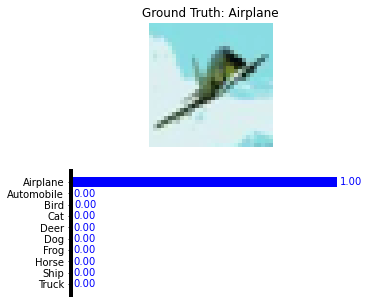

In [12]:
# Choose a picture at random
idx = randint(0, test_size-1)
print(idx)
im, label = test_set[idx]
org_im = inverse_transform(im)

# Send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = im.view(1,3,32,32)

# Feed it to the net and display the confidence scores
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

### Refining the Model

Although the vallina model has achieved fair classification results, the test error is still high remaining huge room for further improvement. There are lots of methods to refine your model, such as **modifying the network architecture** (e.g., making your network deeper), **optimizing the learning strategy** (e.g., optimizer, loss function), and **tuning the hyperparameters** (e.g., learning rate, training iterations), etc. Please try at least **TWO** different methods to improve your model's performance, and discuss why these changes can work. Design and conduct your own experiments using the coding cell below, and present your experimental results and analysis in a decent way (e.g., drawing some neat figures/tables can help to convey your thoughts effectively). 

In [13]:
##############################################################################
# TODO: Conduct experiments to refine your model (e.g., modify the backbone, #
# alter the learning strategy, and tuning the hyperparameters, etc.).        #
##############################################################################

# your code
class ConvNet_R(torch.nn.Module):
    def __init__(self):
        super(ConvNet_R, self).__init__()
        
        ##############################################################################
        # TODO: Define a simple CNN contraining Conv, Pooling, and FC layers.        #
        ##############################################################################
        
        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv1s = nn.Conv2d(64, 64, 3, stride=1, padding=1) #added one more convolutional layer
        self.pool = nn.MaxPool2d(2, 2)
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        #self.conv2s = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        
        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv3s = nn.Conv2d(256, 256, 3, stride=1, padding=1) #added one more convolutional layer
        # Block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.fc1 = nn.Linear(512 * 2 * 2, 2048)
        self.fc2 = nn.Linear(2048, 4096)
        self.fc3 = nn.Linear(4096, 4096)
        self.fc4 = nn.Linear(4096, 10)
        self.dropout = nn.Dropout(0.25) #added one dropout
        #self.dropoutmid = nn.Dropout(0.5)
        self.dropoutsmall = nn.Dropout(0.7) #added one dropout
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        
        ##############################################################################
        # TODO: Implement forward path turning an input image to class probability.  #
        # For activation function, please use ReLU.                                  #
        ##############################################################################

        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16
        #x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1s(x))
        x = self.pool(x)
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.pool(F.relu(self.conv2(x)))
        #x = F.relu(self.conv2(x))
        #x = F.relu(self.conv2s(x))
        #x = self.pool(x)
        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4
        #x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3s(x))
        #x = F.relu(self.conv3s(x))
        x = self.pool(x)
        # Block 4:         256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4(x)
        #z.register_hook(lambda grad: print(grad))
        #z.retain_grad()
        x = self.pool(F.relu(x)) #Add dropout below
        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        #x = self.dropout(x)
        x = x.view(-1, 512 * 2 * 2)
        x = self.dropoutsmall(x)
        x = F.relu(self.fc1(x))
        #x = self.dropoutmid(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = self.fc4(x)
        #softmax = nn.Softmax(dim=-1)
        #x = softmax(x)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        return x
    
model = ConvNet_R()
model.to(device)
print(model)

epochs = 23 #increase number of epochs
batch_size = 128
#batch_size = 100
#learning_rate = 0.25
learning_rate = 0.1 #decrease the learning rate

# Set up optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
# Build data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

ConvNet_R(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1s): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (dropoutsmall): Dropout(p=0.7, inplace=False)
)


In [14]:
# Start training                               #this cell is to actually train the refined CNN
train_net(model)
# Save the trained model
torch.save(model.state_dict(), './model_cnn.pt')

epoch= 0 	 time= 0.96 min 	 loss= 0.018 	 error= 89.98%
error rate on test set = 90.00%
epoch= 1 	 time= 1.83 min 	 loss= 0.018 	 error= 87.52%
error rate on test set = 80.19%
epoch= 2 	 time= 2.85 min 	 loss= 0.016 	 error= 77.50%
error rate on test set = 79.91%
epoch= 3 	 time= 3.90 min 	 loss= 0.015 	 error= 71.30%
error rate on test set = 67.54%
epoch= 4 	 time= 4.81 min 	 loss= 0.013 	 error= 64.22%
error rate on test set = 62.75%
epoch= 5 	 time= 6.01 min 	 loss= 0.012 	 error= 56.66%
error rate on test set = 51.76%
epoch= 6 	 time= 8.08 min 	 loss= 0.011 	 error= 49.20%
error rate on test set = 45.37%
epoch= 7 	 time= 9.07 min 	 loss= 0.009 	 error= 43.72%
error rate on test set = 37.44%
epoch= 8 	 time= 10.25 min 	 loss= 0.008 	 error= 37.81%
error rate on test set = 42.77%
epoch= 9 	 time= 11.25 min 	 loss= 0.007 	 error= 32.78%
error rate on test set = 32.68%
epoch= 10 	 time= 12.62 min 	 loss= 0.006 	 error= 28.79%
error rate on test set = 30.31%
epoch= 11 	 time= 14.02 min 

---

**Write your observations and analysis in this Markdown cell:**
The performance of the CNN has improved because I have made the neural network deeper I have added 2 more convolutional layers, I have also added some dropouts too. I have also decrease the learning rate to 0.1. Increasing the number of epochs also improve the performance of the CNN. In this case, I have increase the number of epochs to 23. 

Large learning rate can cause the model to converge too quickly to a suboptimal solution, so decreasing the learning rate makes the situation better. Making neural network deeper makes it possible to train with more input value, they can also learn features at various levels of abstraction.

Finally adding dropout is able to prevent overfitting of the training data therefore improving the performance of the CNN. Increasing the number of epochs allow for more training sessions with the CNN, which decreasing the training error rate more over time, and improve the test error rate of the CNN.


---

## Task 2: Model Interpretation

The model is doing well, eating images and predicting results; however, everything that happens inside is opaque and hard to explain. So, how can we interpret how CNN sees and understands when making a decision? 

In this section, we are going to explore Grad-CAM, a visual explanation algorithm that generates heatmaps indicating where the network is "looking" in the forward pass.

#### Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM) [1], uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. An overview of the workflow of Grad-CAM is shown below. Please read the paper [1], understand the algorithm, and implement `generate_cam`.

<img src="./figures/gradcam_network.png" width="800"/>

[1] [Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." ICCV 2017.](https://arxiv.org/abs/1610.02391)

In [15]:
gradients = []  # A gloabl variable used to save the gradient
def generate_cam(model, input_image, target_layer='conv4', target_class=None):
    """
    A function to generate Grad-CAM of specific layer and class on an input image using given model.
  
    Inputs
    - model: A PyTorch model.
    - input_image: A PyTorch Tensor of shape (1, C, H, W).
    - target_layer: A String indicating the name of targeted convolutional layer being visualized (e.g., 'conv4').
                    By default, use the last conv layer of the model.
    - target_class: An Integer indicating the lable of targeted class being visualized (e.g., 1). 
                    If None, use the predicted class as target class.
    
    Returns: A NumPy Array of shape (N, C, H, W) showing the intended heatmap.
    """

    ##############################################################################
    # TODO: Given an input image, generate its Grad-CAM on target conv layer     #
    # using the backward gradients from a specific class.                        #
    # 1. Forward the input image, when you also need to register the gradient    #
    # hook so as to get the gradient in backward pass (hint: register_hook).     #
    # 2. Backward pass with specified target class, and get gradients.           #
    # 3. Average each gradient, multiply with its conv output, and sum together. #
    ##############################################################################
    
    # your code
    visualisation = {}



    def hook_fn(m, i, o):
        visualisation[m] = o 


    def get_all_layers(net):            #do a forward hook to all the layers, so as to
        for name, layer in net._modules.items(): #get all the activation map of the convolutional layers
        #If it is a sequential, don't register a hook on it                     
        # but recursively register hook on all it's module children       
            if isinstance(layer, nn.Sequential):
                get_all_layers(layer)
            else:
          # it's a non sequential. Register a hook
                layer.register_forward_hook(hook_fn)


    def get_backward_layers(net):         #do a backward hook to all the layers, so as to
        for name, layer in net._modules.items():  #get all the gradients of the convolutional layers
        #If it is a sequential, don't register a hook on it                    
        # but recursively register hook on all it's module children
            if isinstance(layer, nn.Sequential):
                get_all_layers(layer)
            else:
          # it's a non sequential. Register a hook
                layer.register_full_backward_hook(hook_fn)
    global label
    label = torch.tensor([label]).to(device)
    get_all_layers(model)
    get_backward_layers(model)
    outp = model(input_image)
    
    visualisation_copy = visualisation.copy() #visualisation_copy is a dictionary with values of activation map
    cam = visualisation_copy.get(model._modules.get(target_layer)) #access the activation map depending on what convolutional
    #layer the user wants
    loss = criterion(outp, label)
    loss.backward()  #do a backward pass to get gradient
        
    for i in range(cam.shape[1]):
        cam[:, i, :, :] *= torch.mean(visualisation.get(model._modules.get(target_layer))[0], dim=[0, 2, 3])[i]#average each gradient
    cam = torch.sum(cam, dim = 1) #sum together
    cam = cam.cpu().detach().numpy() #conversion to numpy form
    cam = cam.reshape(cam.shape[-2],cam.shape[-1]) #reshape to proper 2 dimensional array
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    # Post processing
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
    cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                    input_image.shape[3]), Image.ANTIALIAS))

    return cam

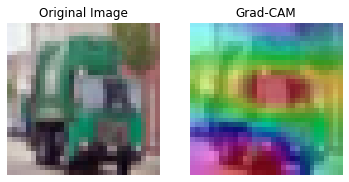

In [16]:
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

ax = plt.subplot(1, 2, 1)
ax.imshow(org_im)
ax.set_title('Original Image')
ax.set_axis_off()

cam = generate_cam(model, im)
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 2, 2)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM')
ax.set_axis_off()

### Performing Visual Explanation

Now you have successfully built a powerful tool (i.e., Grad-CAM) that can assist you to visualize and understand the CNN models. Try to make full use of `generate_cam` and design at least **TWO** experiments that can further explain how CNN sees and understands the images. For example, apply Grad-CAM on different layers and compare their differences. Please quantitatively show some evidence (e.g., plotting some examplar images clearly and elegantly) with necessary code snippets, write down your observations and briefly explain each. 

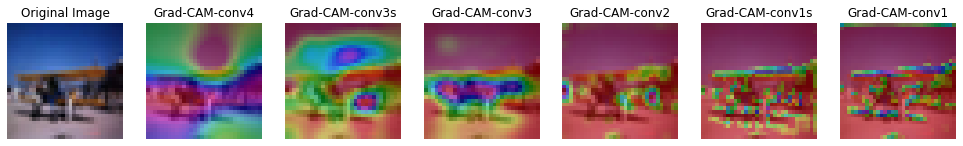

In [19]:
##############################################################################
# TODO: Write code snippets to present your experiments (hint: if you want   #
# to plot multiple images in one single figure, plt.subplot should help).    #
##############################################################################

# your code
from matplotlib.pyplot import figure
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

figure(figsize=(17, 17))

ax = plt.subplot(1, 7, 1)  #middle value is how many plots, rightmost value means the location, 1st, 2nd or 3rd.
ax.imshow(org_im)
ax.set_title('Original Image')             #this cell is showing all the Grad-CAM for different convolutional layers
ax.set_axis_off()

cam = generate_cam(model, im, 'conv4')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 7, 2)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM-conv4')
ax.set_axis_off()

cam = generate_cam(model, im, 'conv3s')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 7, 3)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM-conv3s')
ax.set_axis_off()

cam = generate_cam(model, im, 'conv3')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 7, 4)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM-conv3')
ax.set_axis_off()

cam = generate_cam(model, im, 'conv2')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 7, 5)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM-conv2')
ax.set_axis_off()

cam = generate_cam(model, im, 'conv1s')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 7, 6)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM-conv1s')
ax.set_axis_off()

cam = generate_cam(model, im, 'conv1')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 7, 7)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM-conv1')
ax.set_axis_off()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**
From what I observe after applying Grad-CAM on the different convolutional layers of the CNN. The first few convolutional layers, not much heat map is involved only a little bit of it to cover some features of the object in the image. As the convolutional layers progress, the heatmap starts to intensify, it starts to spread to more parts of the features in the image.

At the very end/last convolutional layer, the heatmap would be at the peak of its intensification, it will also become more localised and should be aiming at the object specifically in the image. Sometimes the heatmap is not localised and overspreading across the image, I believe that could be an indication of overbuilding the architecture of the CNN, so it has decrease the overall performance of the CNN.

---

## Task 3: Adversarial Attack

After going through some testing results in Task 1, you might think in most cases the model performs pretty well, predicting the correct classes with high confidence, and rarely making mistakes. However, the network is not as strong as you think. The network can be vulnerable and easily fooled by simply adding some very small distributions on input images. In this section, we are going to attack our previously trained model by generating adversarial images that visually look alike but crush the model without striking a blowing.

### Adversarial Examples

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These examples are usually generated by adding imperceptible non-random perturbations to the image, which are indistinguishable to human eye, but can cause the network to fail to identify the contents of the image. There are many kinds of such attack strategies, here we focus on the **Fast Gradient Sign Method (FGSM)** [2]. FGSM is a white box attack where the attacker has complete access to the model being attacked. The method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. Below shows a famous exmaple taken from the paper [2], where the classification of image showing "panda" is changed to "gibbon" after adding an imperceptibly small vector: $\text{sign}(\nabla_xJ(\theta, x, y))$.

<img src="./figures/adversarial_example.png" width="800"/>

Read the paper [2] for more details, and then implement the following function `generate_adv_image`, which generates "fooling images" of target class to attack your network. 

[2] [Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.](https://arxiv.org/abs/1412.6572)

In [20]:
def generate_adv_image(model, inputs, labels, targets=None, eps=0.2):
    """
    A function to generate adversarial examples.
  
    Inputs
    - model: A PyTorch model.
    - inputs: Input images, a PyTorch Tensor of shape (N, C, H, W).
    - labels: Ground truth labels of input images, a PyTorch Tensor of shape (N,).
    - targets: The target classes you want the model to misclassify, a PyTorch Tensor of shape (N,).
    
    Returns: The adversarial examples of given images.
    """


    ##############################################################################
    # TODO: Implement Fast Gradient Sign Method to generate an adversarial image #
    # that fools the model to predict incorrect class.                           #   
    # 1. Get the gradients of the loss w.r.t to the input image.                 #
    # 2. Get the sign of the gradients to create the perturbation.               #
    # 3. Add the perturbation to the input image.                                #
    ##############################################################################
    
    # your code
    if targets is None: #this is for non-targeted adversarial attack
        
        labels = torch.tensor([labels]).to(device)
        inputs.requires_grad = True #set input image to have required_grad = True
        output = model(inputs)
        loss = criterion(output, labels)
    
        loss.backward() #backward pass to get gradient
    
        sign_data_grad = inputs.grad.sign() #get the sign of the gradients to create the perturbation
    
        adv_inputs = inputs + eps*sign_data_grad #add the perturbation to the input image
    
    else: #this is for targeted adversarial attack
        delta = torch.zeros_like(inputs, requires_grad=True) #delta is the noise
        labels = torch.tensor([labels]).to(device)
        for t in range(40): 
    
            output = model(inputs + delta)
    
            loss = (output[:,targets] - output.gather(1,labels[:,None])[:,0]).sum() #compute the loss
            loss.backward() #do a backward pass on the loss
            delta.data = (delta + 1e-2*delta.grad.detach().sign()).clamp(-eps,eps) #update the delta
            delta.grad.zero_() #reset delta gradient to zero
        adv_inputs = inputs + delta.data #after the iteration, add the delta noise to the input image
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    return adv_inputs.detach()

### Attacking the Model

Randomly pick up some images from test set, and attack the model using adversarial examples generated by `generate_adv_image`.

Before attack:


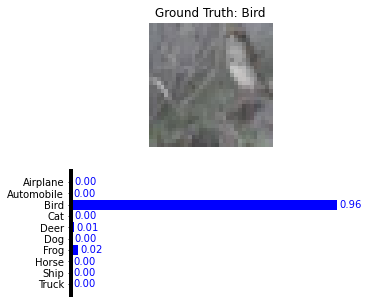

After attack:


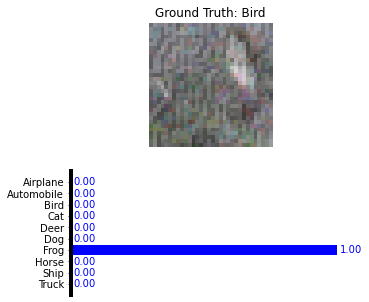

In [21]:
idx = randint(0, len(test_set)-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

print('Before attack:')
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

adv_im = generate_adv_image(model, im, label)

print('After attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

Run evaluation on the testing set to see how the model performs on the generated adversarial examples, and compare with results before attacks. Try different parameters (e.g., `targets`, `eps`), describe your observations with a brief explanation in the below cell. 

After targeted attack:


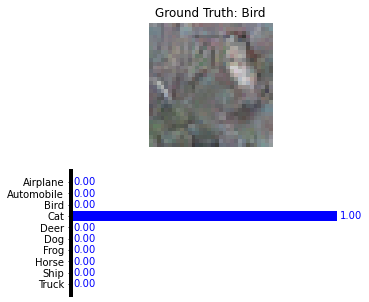

After targeted attack:


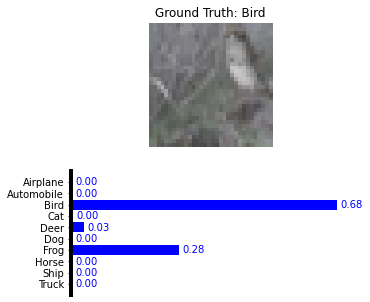

After targeted attack:


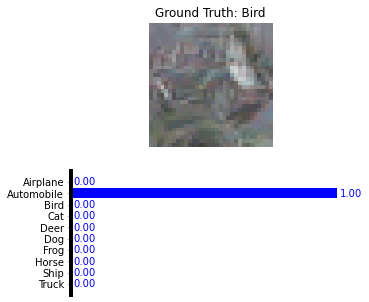

After targeted attack:


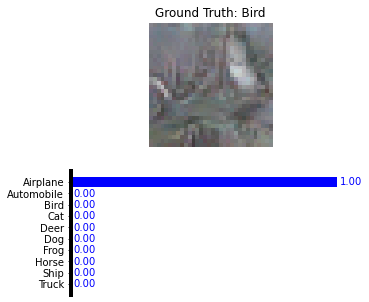

After targeted attack:


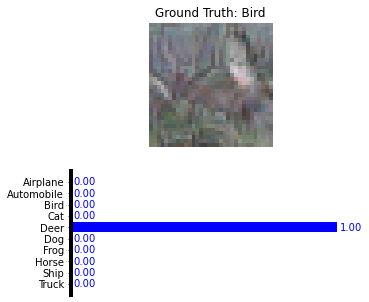

After targeted attack:


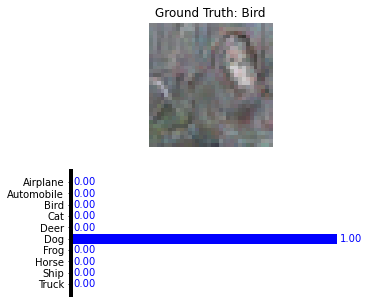

After targeted attack:


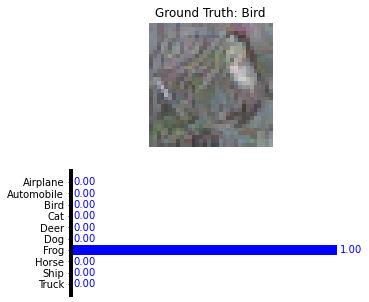

After targeted attack:


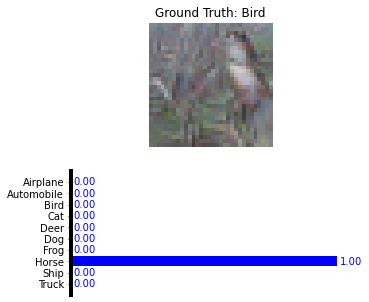

After targeted attack:


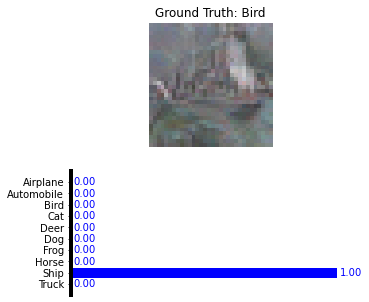

After targeted attack:


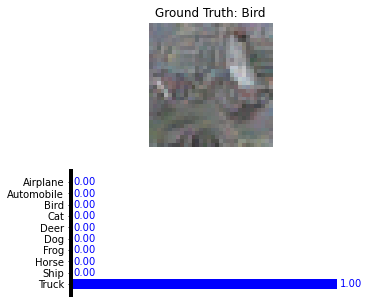

In [22]:
##############################################################################
# TODO: Evaluate error rate on adversarial images generated from testing set #
# with different parameter settings.                                         #
##############################################################################

# your code
adv_im = generate_adv_image(model, im, label, 3) #this cell is to show the effect of targeted adversarial attack, take for 
#adv_im = generate_adv_image(model, im, 1) #example I want to misclassify the image to class 3 which is cat

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 2) #misclassify the image to class 2 which is bird 
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 1) #misclassify the image to class 1 which is automobile and so on.
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 0)
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 4)
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 5)
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 6)
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 7)
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 8)
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

adv_im = generate_adv_image(model, im, label, 9)
#adv_im = generate_adv_image(model, im, 1)

print('After targeted attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [23]:
def generate_adv_image_batch(model, inputs, labels, eps, targets=None): #this function is generating adv_images in batches
    #because we are going to use the test_set which is written earlier previously.
    """
    A function to generate adversarial examples.
  
    Inputs
    - model: A PyTorch model.
    - inputs: Input images, a PyTorch Tensor of shape (N, C, H, W).
    - labels: Ground truth labels of input images, a PyTorch Tensor of shape (N,).
    - targets: The target classes you want the model to misclassify, a PyTorch Tensor of shape (N,).
    
    Returns: The adversarial examples of given images.
    """


    ##############################################################################
    # TODO: Implement Fast Gradient Sign Method to generate an adversarial image #
    # that fools the model to predict incorrect class.                           #   
    # 1. Get the gradients of the loss w.r.t to the input image.                 #
    # 2. Get the sign of the gradients to create the perturbation.               #
    # 3. Add the perturbation to the input image.                                #
    ##############################################################################
    
    # your code
    #labels = torch.tensor([labels]).to(device)
    inputs.requires_grad = True #code is largely similar as the first just that the labels now become a tensor instead of a 
    #single float so there is no need to convert to tensor in the first place.
    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    #inputs.grad ###
    sign_data_grad = inputs.grad.sign()
    adv_inputs = inputs + eps*sign_data_grad
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    return adv_inputs.detach()

def eval_on_test_set_adv(model, eps):
    model.eval()
    running_error = 0

    for data in test_loader:
        
        ##############################################################################
        # TODO: Implement the evaluation process on test set.                        #
        ##############################################################################

        # Load inputs and labels and deploy to running device
        data[0] = data[0].to(device)
        data[1] = data[1].to(device)
        # Get the adv_im using generate_adv_image_batch.
        adv_im = generate_adv_image_batch(model, data[0], data[1], eps)
        outputs = model(adv_im)
        # Compute the error made on this batch and add it to the running error
        _, predicted = torch.max(outputs, 1)
        running_error += (predicted != data[1]).sum().item()
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
    total_error = running_error / test_size
    print('error rate on test set = {:.2f}%'.format(total_error * 100))
    
eps_list = [0.01, 0.03, 0.07]
for item in eps_list:
    eval_on_test_set_adv(model, item)

error rate on test set = 36.84%
error rate on test set = 62.94%
error rate on test set = 82.15%


---

**Write your observations and analysis in this Markdown cell:**
Targeted Adversarial attack works pretty well because the images are misclassified desirably according to the classes I want. The larger the epsilon value inside the clamp, the better is the misclassification. Also adding more iterations can help with the effect of the targeted adversarial attack.


For the second cell, I try to show the effect of epsilon value on the adversarial attack. It has shown that the larger the epsilon value, the higher the error rate on test set. This is because epsilon bounds the total number of pixels in x' that can be modified with respect to x. So higher epsilon will result in more pixels in x' to be modified with respect to x.

---